In [1]:
import zlib
import gzip
import psycopg2
import pandas as pd

## 1. Connect with mimic database

In [2]:
conn = psycopg2.connect(host='madigun.asuscomm.com', port='5432', database='mimic', user='grace', password="grace0410")
cur = conn.cursor()

## 2. Fetch required data

In [3]:
df = pd.read_sql('''SELECT
                              DISTINCT (icd9_code)
                            FROM (SELECT
                                    subject_id,
                                    hadm_id
                                  FROM admissions a
                                  WHERE admission_type IN ('EMERGENCY', 'URGENT')) e
                              LEFT JOIN patients p
                                ON e.subject_id = p.subject_id
                              INNER JOIN (SELECT *
                                          FROM diagnoses_icd
                                          WHERE seq_num = 1
                                                AND icd9_code IS NOT NULL) AS d
                                ON e.hadm_id = d.hadm_id;''', conn)

In [4]:
df.head()

,icd9_code
0,86802
1,8742
2,2880
3,4232
4,3202


According to mimic, "the code field for the ICD-9-CM Principal and Other Diagnosis Codes is six characters in length, with the decimal point implied between the third and fourth digit for all diagnosis codes other than the V codes. The decimal is implied for V codes between the second and third digit".

- XXXXXX -> XXX.XXX
- VXXXXX -> VXX.XXX

In [5]:
def reformat_icd9(code):
    if code.find('V') <0 :
        if len(code) == 3:
            return code
        else:
            return '.'.join([code[:3] , code[3:]])
    else:
        if len(code) ==3:
            return code
        else:
            return '.'.join([code[:3] , code[3:]])

In [6]:
df['icd9_code_format'] = df.icd9_code.apply(lambda x: reformat_icd9(x) )

In [7]:
df.shape

(2532, 2)

In [8]:
df.head()

,icd9_code,icd9_code_format
0,86802,868.02
1,8742,874.2
2,2880,288.0
3,4232,423.2
4,3202,320.2


ICD9 code 구조는 다음과 같다.  
- https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9
- https://www2.gov.bc.ca/assets/gov/health/practitioner-pro/medical-services-plan/diag-codes-index.pdf

Index
- 001 - 139.8 : Infections and parasitic diseases
- 140 - 239.9 : Neoplasms
- 240 - 279.9 : Endocrine, nutritional and metabolic diseases and immunity disorders
- 280 - 289.9 : Diseases of blood and blood forming organs
- 290 - 319 : mental disorders
- 320 - 389.9 : Diseases of nervous system and sense organs
- 390 - 459.9 : Disease of the circulatory system
- 460 - 519.9 : Disease of the respiratory system
- 520 - 579.9 : Disease of the digestive system
- 580 - 629.9 : Disease of genitourinary system
- 630 - 676.9 : Complications of pregnancy, childbirth and the puerperium
- 680 - 709.9 : diseases of the skin and subsutaneous tissue
- 710 - 739.9 : Diseases of musculoskeletal system and connective tissue
- 740 - 759.9 : Congenital anomalies
- 760 - 779.9 : Certain conditions originating in the perinatal period
- 780 - 799.9 : Symptoms, signs and ill-defined conditions
- 800 - 999.9 : injury and poisoning
- V01 - V82.9 : Supplementary classifications of factors influencing health status and contact with health services

In [9]:
# code categories with starting index
CODE_INDEX = {1: '001', 2: '140', 3: '240', 4: '280', 5: '290', 6: '320', 7: '390', 8: '460', 9: '520', 10: '580', 11: '630', 12: '680', 13: '710', 14: '740', 15: '760', 16: '780', 17: '800', 18: 'V01'}

In [10]:
def find_index_range_recursively(code, code_index_pos):
    if code > 999.9:
        raise CodeIndexError('Code not in appropriate range')
    
    try:
        if code >= float(CODE_INDEX[code_index_pos]):
            return find_index_range_recursively(code, code_index_pos+1)
        else:
            return code_index_pos - 1
    except ValueError:
            return code_index_pos - 1 

In [59]:
icd9_categories = {i:list() for i in CODE_INDEX.keys()}

def  get_category_counts(code):
    if code.find('V') >= 0:
        icd9_categories[18].append(code)
        return 18
    else:
        c_index = find_index_range_recursively(float(code), 1)
        icd9_categories[c_index].append(code)
        return c_index

In [60]:
df.icd9_code_format.apply(lambda x: get_category_counts(x))

0       17
1       17
2        4
3        7
4        6
5        9
6       17
7       17
8       17
9       17
10      16
11      17
12       1
13       2
14       7
15       2
16       2
17      17
18       9
19      17
20       9
21      16
22       9
23      17
24      17
25       7
26      17
27       4
28      17
29       1
        ..
2502     1
2503     8
2504     8
2505     2
2506    17
2507    13
2508     9
2509     5
2510    17
2511    17
2512     7
2513    17
2514     2
2515    17
2516    17
2517    17
2518     5
2519     9
2520    17
2521    17
2522     9
2523    16
2524    16
2525    17
2526     9
2527     2
2528     9
2529    17
2530     7
2531     9
Name: icd9_code_format, Length: 2532, dtype: int64

In [13]:
# 각 카테고리별 진단 갯수를 파악해보기
for k, v in icd9_categories.items():
    print('{} : {}'.format(k, len(v)))

1 : 124
2 : 243
3 : 108
4 : 45
5 : 52
6 : 103
7 : 254
8 : 137
9 : 242
10 : 68
11 : 80
12 : 32
13 : 82
14 : 36
15 : 44
16 : 67
17 : 794
18 : 21


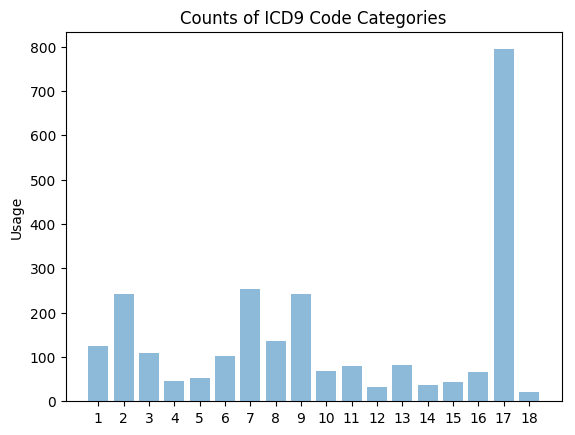

In [15]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

categories = icd9_categories.keys()
y_pos = np.arange(len(categories))
counts = [len(icd9_categories[k]) for k in categories]

plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.ylabel('Usage')
plt.title('Counts of ICD9 Code Categories')

plt.show()

## 3. Get embeddings

In [16]:
DIMENSION = 300

with gzip.open('./data/claims_codes_hs_300.txt.gz', 'rb') as f:
    file_content = f.read()

In [17]:
file_content = file_content.split(b'\n')
file_content = file_content[2:]

In [18]:
file_content  = list(filter(lambda x: x[0].find(b'IDX')>=0, map(lambda x: x.split(b' '), file_content)))

file_content = { i[0].decode('ASCII') : i[1:DIMENSION + 1] for i in file_content}

In [26]:
icd_embeddings = {}

not_found_codes = []
for ind, row in df.iterrows():
    code = row['icd9_code_format']
    
    try:    
        code_emb = np.array(file_content['IDX_'+code])
        icd_embeddings[code] = code_emb.astype(float)

    except KeyError:
        print('IDX_'+code)
        not_found_codes.append(code)
        not_found_codes.append(code[:-1])
#         file_content['IDX_'+code[:-1]]

IDX_803.75
IDX_532.61
IDX_863.83
IDX_861.13
IDX_804.16
IDX_801.74
IDX_015.05
IDX_902.29
IDX_800.24
IDX_801.52
IDX_803.15
IDX_018.94
IDX_806.16
IDX_801.35
IDX_801.45
IDX_804.23
IDX_852.39
IDX_804.75
IDX_887.5
IDX_800.75
IDX_803.12
IDX_801.65
IDX_804.12
IDX_801.60
IDX_018.05
IDX_804.21
IDX_863.93
IDX_851.75
IDX_851.62
IDX_804.36
IDX_635.22
IDX_999.84
IDX_851.73
IDX_695.14
IDX_801.82
IDX_976.2
IDX_803.11
IDX_803.24
IDX_V31.1
IDX_800.60
IDX_801.96
IDX_853.16
IDX_804.22
IDX_804.70
IDX_804.25
IDX_902.87
IDX_852.32
IDX_634.51
IDX_004.1
IDX_801.62
IDX_323.51
IDX_852.45
IDX_801.23
IDX_801.72
IDX_804.32
IDX_012.05
IDX_801.13
IDX_927.01
IDX_801.15
IDX_800.15
IDX_018.03
IDX_861.12
IDX_851.31
IDX_852.12
IDX_013.04
IDX_851.03
IDX_665.24
IDX_804.73
IDX_801.24
IDX_005.1
IDX_969.01
IDX_801.14
IDX_801.80
IDX_806.07
IDX_851.25
IDX_202.43
IDX_989.3
IDX_851.83
IDX_851.21
IDX_804.41
IDX_800.81
IDX_800.35
IDX_803.60
IDX_861.03
IDX_800.25
IDX_013.25
IDX_458.2
IDX_801.75
IDX_800.65
IDX_062.2
IDX_200.22
IDX_901

In [27]:
for n_code in not_found_codes:
    print(n_code)
    print(list(filter(lambda x: x.find(n_code)>=0, file_content.keys())))

803.75
[]
803.7
['IDX_803.76']
532.61
[]
532.6
['IDX_532.60']
863.83
[]
863.8
['IDX_863.89', 'IDX_863.80', 'IDX_863.84', 'IDX_863.81']
861.13
[]
861.1
['IDX_861.10', 'IDX_861.11']
804.16
[]
804.1
['IDX_804.10', 'IDX_E804.1']
801.74
[]
801.7
['IDX_801.76', 'IDX_801.70', 'IDX_801.71']
015.05
[]
015.0
['IDX_E015.0', 'IDX_015.00']
902.29
[]
902.2
['IDX_902.20', 'IDX_902.21', 'IDX_902.22', 'IDX_902.25', 'IDX_902.23']
800.24
[]
800.2
['IDX_800.20', 'IDX_800.26', 'IDX_800.22', 'IDX_800.21', 'IDX_800.29', 'IDX_800.23']
801.52
[]
801.5
['IDX_801.51', 'IDX_801.50']
803.15
[]
803.1
['IDX_803.10']
018.94
[]
018.9
['IDX_018.90']
806.16
[]
806.1
['IDX_806.10', 'IDX_806.12']
801.35
[]
801.3
['IDX_801.30', 'IDX_801.36', 'IDX_801.31', 'IDX_801.32']
801.45
[]
801.4
['IDX_801.46', 'IDX_801.40', 'IDX_801.41', 'IDX_801.42']
804.23
[]
804.2
['IDX_804.20', 'IDX_804.26']
852.39
[]
852.3
['IDX_852.30', 'IDX_852.36', 'IDX_852.31']
804.75
[]
804.7
[]
887.5
[]
887.
['IDX_887.0', 'IDX_887.2', 'IDX_887.1', 'IDX_887

In [28]:
# 활용하지 않도록 권고된 코드가 입력된 경우가 있다.
# http://www.icd9data.com/2012/Volume1/390-459/451-459/458/458.2.htm
# There are 2 ICD-9-CM codes below 458.2 that define this diagnosis in greater detail. Do not use this code on a reimbursement claim.

df[df.icd9_code_format=='458.2']
# 458.2 (Iatrogenic Hypertension)하위 코드로는 456.21(Hypotension of hemodialysis), 456.29(Other iatrogenic hypertension)이 존재함으로 둘의 평균을 입력

np_lower = np.array([file_content['IDX_458.21'], file_content['IDX_458.29']])
np_lower = np_lower.astype(float)
np_lower = np.mean(np_lower, axis=0)
print(np_lower.shape)

icd_embeddings['458.2'] =  np_lower

(300,)


In [55]:
from sklearn.manifold import TSNE
from numpy import vstack
import seaborn as sns

In [48]:
data = vstack(icd_embeddings.values())

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2418 samples in 0.026s...
[t-SNE] Computed neighbors for 2418 samples in 5.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2418
[t-SNE] Computed conditional probabilities for sample 2000 / 2418
[t-SNE] Computed conditional probabilities for sample 2418 / 2418
[t-SNE] Mean sigma: 1.203152
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.050430
[t-SNE] KL divergence after 300 iterations: 1.510324


In [61]:
df_emb = pd.DataFrame(icd_embeddings.items())
df_emb.columns = ['code', 'embedding']
df_emb['y'] = df_emb.code.apply(lambda x: get_category_counts(x))
df_emb.shape

(2418, 3)

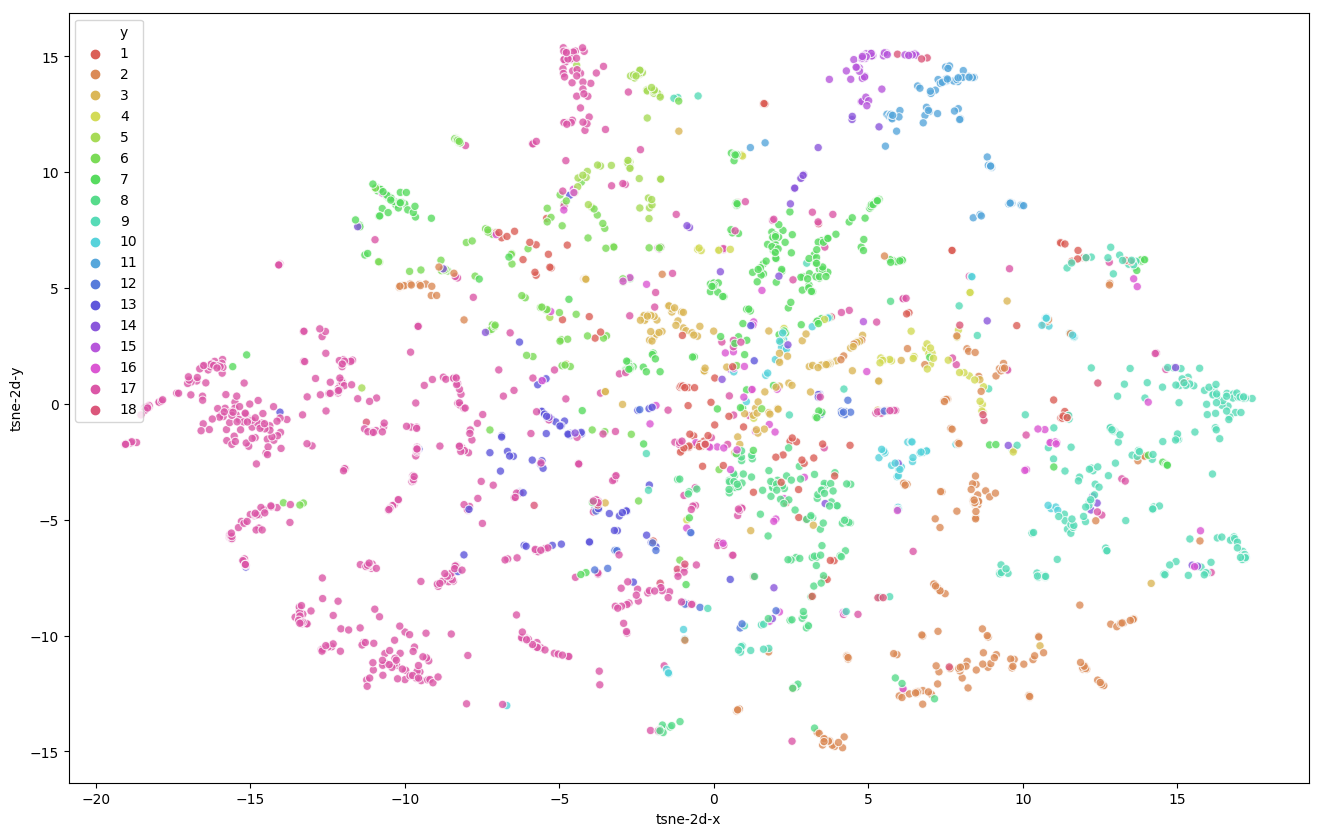

In [74]:
df_emb['tsne-2d-x'] = tsne_results[:,0]
df_emb['tsne-2d-y'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-x", y="tsne-2d-y",
    hue="y",
    palette=sns.color_palette("hls", 18),
    data=df_emb,
    legend="full",
    alpha=0.8
)